# **Environmental Sound Classification using Deep CNNs and Augmented Spectrograms**

**ANNA ESE Project**

Group Members:
- Kaustubh Wagh [202201070021]
- Nikita Kadam [202201070024]
- Apoorva Singh [202201070030]
- Yash Sawant [202201070032]

---



### Library Installation

Installs essential libraries:

- **librosa**: Audio processing
- **numpy**: Numerical operations
- **matplotlib**: Plotting
- **scikit-learn**: Machine learning tools
- **tensorflow**: Deep learning framework
- **pandas**: Data handling (CSV, tables)


In [ ]:
%pip install librosa numpy matplotlib scikit-learn tensorflow pandas

### Device Setup

Checks if a GPU (CUDA) is available and sets it as the computing device. Falls back to CPU if not.



In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


### mounting google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!cp -r /content/UrbanSound8K /content/drive/MyDrive/


cp: cannot stat '/content/UrbanSound8K': No such file or directory


In [ ]:
# Download UrbanSound8K from the official website
!wget https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz

# Extract it
!tar -xzf UrbanSound8K.tar.gz


--2025-05-23 06:15:14--  https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz
Resolving zenodo.org (zenodo.org)... 188.185.43.25, 188.185.48.194, 188.185.45.92, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.25|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/1203745/files/UrbanSound8K.tar.gz [following]
--2025-05-23 06:15:14--  https://zenodo.org/records/1203745/files/UrbanSound8K.tar.gz
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 6023741708 (5.6G) [application/octet-stream]
Saving to: ‘UrbanSound8K.tar.gz’

UrbanSound8K.tar.gz  17%[==>                 ]   1023M  21.6MB/s    eta 5m 36s ^C

gzip: stdin: unexpected end of file
tar: Unexpected EOF in archive
tar: Unexpected EOF in archive
tar: Error is not recoverable: exiting now


In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os


In [ ]:
metadata = pd.read_csv("/content/UrbanSound8K/metadata/UrbanSound8K.csv")
metadata.head()


,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


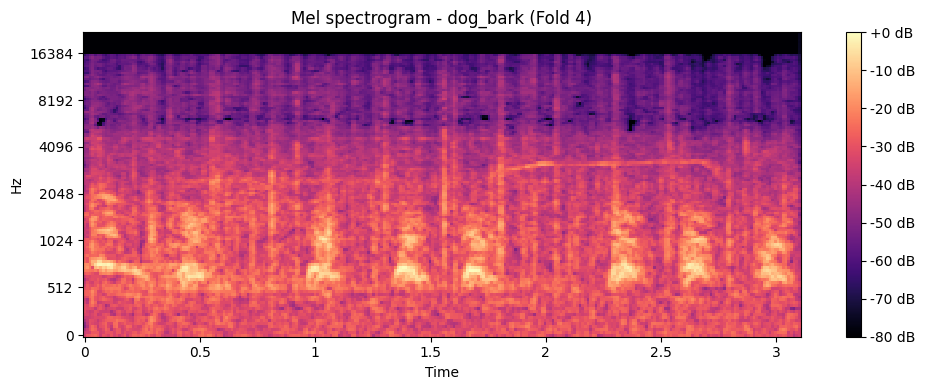

In [ ]:
# Sample row
row = metadata.iloc[100]

file_name = row['slice_file_name']
fold = row['fold']
file_path = f"UrbanSound8K/audio/fold{fold}/{file_name}"

# Load audio
signal, sr = librosa.load(file_path, sr=None)  # keep original sampling rate

# Create mel spectrogram
S = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=128)
S_dB = librosa.power_to_db(S, ref=np.max)

# Display it
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title(f"Mel spectrogram - {row['class']} (Fold {fold})")
plt.tight_layout()
plt.show()


In [ ]:
pip install audiomentations

In [ ]:
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift
import numpy as np
import librosa

# Define augmentation pipeline (transformations to make traning  data more varied and reduce overfitting)
augment = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    Shift(min_shift=-0.5, max_shift=0.5, rollover=True, p=0.5),  ])

def extract_mel_spectrogram(file_path, n_mels=128, duration=4, sr=22050, augment_audio=False):
    samples = duration * sr

    # Load raw audio
    signal, _ = librosa.load(file_path, sr=sr)

    # Pad or trim to fixed length
    if len(signal) < samples:
        signal = np.pad(signal, (0, samples - len(signal)))
    else:
        signal = signal[:samples]

    # 🎛️ Apply augmentation if requested
    if augment_audio:
        signal = augment(samples=signal, sample_rate=sr)

    # Create Mel Spectrogram
    mel_spec = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=n_mels)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db


In [ ]:
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import numpy as np

X = []
y = []

# looping through dataset
for i, row in tqdm(metadata.iterrows(), total=len(metadata)):
    file_name = row["slice_file_name"]
    fold = row["fold"]
    label = row["classID"]
    file_path = f"UrbanSound8K/audio/fold{fold}/{file_name}"

    try:
        augment_audio = fold <= 8

        mel_spec = extract_mel_spectrogram(file_path, augment_audio=augment_audio)
        mel_spec = mel_spec[..., np.newaxis]  # shape: (128, time, 1)
        X.append(mel_spec)
        y.append(label)
    except Exception as e:
        print(f"Error with file {file_path}: {e}")



100%|██████████| 8732/8732 [09:07<00:00, 15.93it/s]


In [ ]:
#checking shapes of X and y
X = np.array(X)
y = np.array(y)
print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (8732, 128, 173, 1)
y shape: (8732,)


In [ ]:
#One-Hot encoding and train-test split
import numpy as np

def one_hot_encode(labels, num_classes):
    return np.eye(num_classes)[labels]

y_cat = one_hot_encode(y, num_classes=10)


In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y_cat, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)


In [ ]:
print("Train:", X_train.shape, y_train.shape)
print("Val:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)


Train: (6985, 128, 173, 1) (6985, 10)
Val: (873, 128, 173, 1) (873, 10)
Test: (874, 128, 173, 1) (874, 10)


CNN Definition

In [ ]:
import torch

# X shape: (num_samples, 128, 173, 1) — need to rearrange to (num_samples, channels, height, width)
# PyTorch expects channel first format: (N, C, H, W)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).permute(0, 3, 1, 2)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2)

# Labels: if one-hot encoded, convert back to class indices
y_train_tensor = torch.tensor(y_train.argmax(axis=1), dtype=torch.long)
y_val_tensor = torch.tensor(y_val.argmax(axis=1), dtype=torch.long)
y_test_tensor = torch.tensor(y_test.argmax(axis=1), dtype=torch.long)


In [ ]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 16

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# CNN model (Conv + BatchNorm + ReLU + MaxPool)
class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))  # Global Avg Pooling
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)  # flatten
        x = self.dropout(x)
        x = self.fc(x)
        return x


In [ ]:
import torch.optim as optim
import torch.nn as nn # Import nn for CrossEntropyLoss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ImprovedCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=50):
    best_val_acc = 0.0
    train_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / total
        train_acc = correct / total
        val_acc = evaluate_model(model, val_loader)

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} - Train loss: {train_loss:.4f} - Train acc: {train_acc:.4f} - Val acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_cnn_model.pth")
            print("Saved best model")

    return train_losses, train_accuracies, val_accuracies


def evaluate_model(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    return correct / total


In [ ]:
train_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, epochs=50
)


# Load best model and test accuracy
model.load_state_dict(torch.load("best_cnn_model.pth"))
test_acc = evaluate_model(model, test_loader)
print(f"Test Accuracy: {test_acc:.4f}")


Epoch 1/50 - Train loss: 0.2113 - Train acc: 0.9293 - Val acc: 0.8877
Saved best model
Epoch 2/50 - Train loss: 0.2284 - Train acc: 0.9263 - Val acc: 0.8637
Epoch 3/50 - Train loss: 0.2293 - Train acc: 0.9284 - Val acc: 0.8832
Epoch 4/50 - Train loss: 0.2352 - Train acc: 0.9257 - Val acc: 0.8946
Saved best model
Epoch 5/50 - Train loss: 0.2114 - Train acc: 0.9349 - Val acc: 0.8832
Epoch 6/50 - Train loss: 0.2213 - Train acc: 0.9309 - Val acc: 0.8740
Epoch 7/50 - Train loss: 0.2117 - Train acc: 0.9341 - Val acc: 0.8877
Epoch 8/50 - Train loss: 0.2100 - Train acc: 0.9317 - Val acc: 0.8820
Epoch 9/50 - Train loss: 0.2202 - Train acc: 0.9300 - Val acc: 0.8900
Epoch 10/50 - Train loss: 0.2259 - Train acc: 0.9271 - Val acc: 0.8683
Epoch 11/50 - Train loss: 0.2106 - Train acc: 0.9313 - Val acc: 0.9049
Saved best model
Epoch 12/50 - Train loss: 0.2069 - Train acc: 0.9314 - Val acc: 0.9003
Epoch 13/50 - Train loss: 0.2090 - Train acc: 0.9331 - Val acc: 0.8671
Epoch 14/50 - Train loss: 0.2036 - 

In [ ]:
model.load_state_dict(torch.load("best_cnn_model.pth"))
model.to(device)


ImprovedCNN(
  (conv_block1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (global_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (dropout): Dropout(p=0.5, inplace=Fals

In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix # Import necessary functions
def evaluate_and_report(model, test_loader):
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)     # move to GPU/CPU
            labels = labels.to(device)     # move to GPU/CPU

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())     # move back to CPU for numpy ops
            all_labels.extend(labels.cpu().numpy())

    print("Classification Report:")
    print(classification_report(all_labels, all_preds, digits=4))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


Classification Report:
              precision    recall  f1-score   support

           0     0.8318    0.8900    0.8599       100
           1     1.0000    0.8605    0.9250        43
           2     0.8058    0.8300    0.8177       100
           3     0.9381    0.9100    0.9239       100
           4     0.8889    0.9600    0.9231       100
           5     0.9485    0.9200    0.9340       100
           6     0.9737    0.9737    0.9737        38
           7     0.9175    0.8900    0.9036       100
           8     0.8632    0.8817    0.8723        93
           9     0.8947    0.8500    0.8718       100

    accuracy                         0.8936       874
   macro avg     0.9062    0.8966    0.9005       874
weighted avg     0.8957    0.8936    0.8939       874



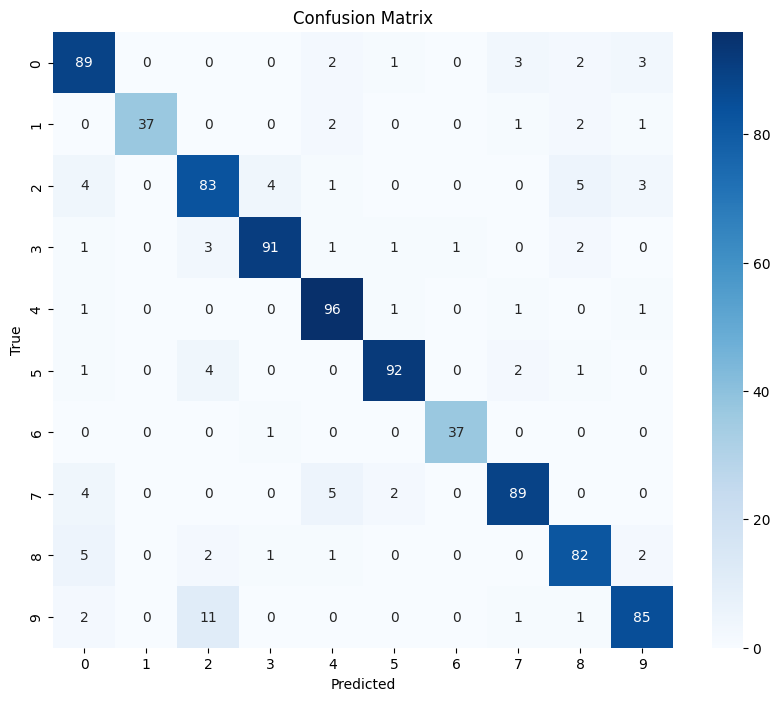

In [ ]:
model.load_state_dict(torch.load("best_cnn_model.pth"))
model.to(device)  # move model to same device as inputs
evaluate_and_report(model, test_loader)


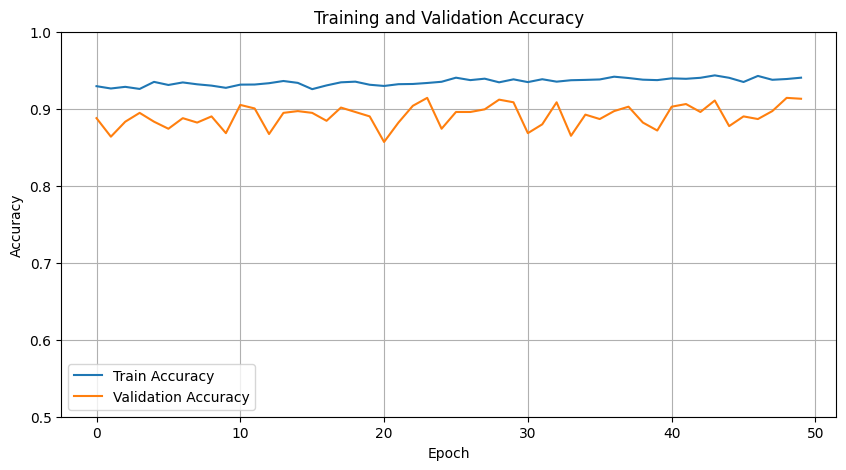

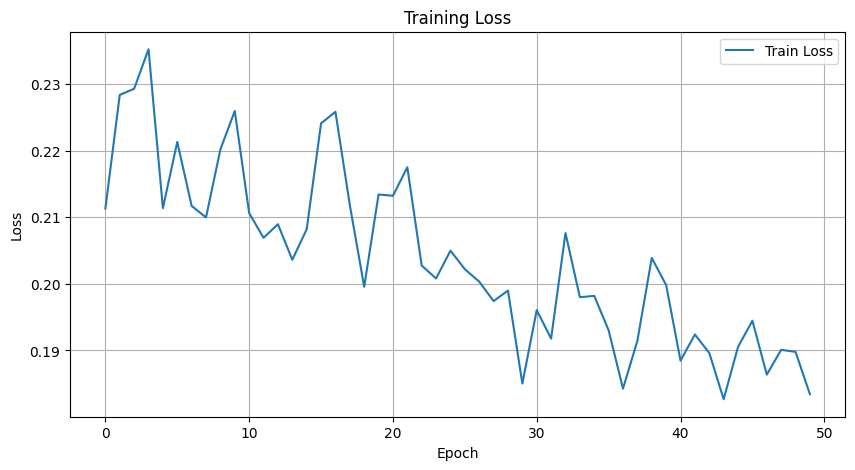

In [ ]:
import matplotlib.pyplot as plt

# Accuracy curves
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.ylim(0.5, 1.0)  # Set y-axis from 50% to 100%
plt.legend()
plt.grid(True)
plt.show()

# Loss curve
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True)
plt.legend()
plt.show()


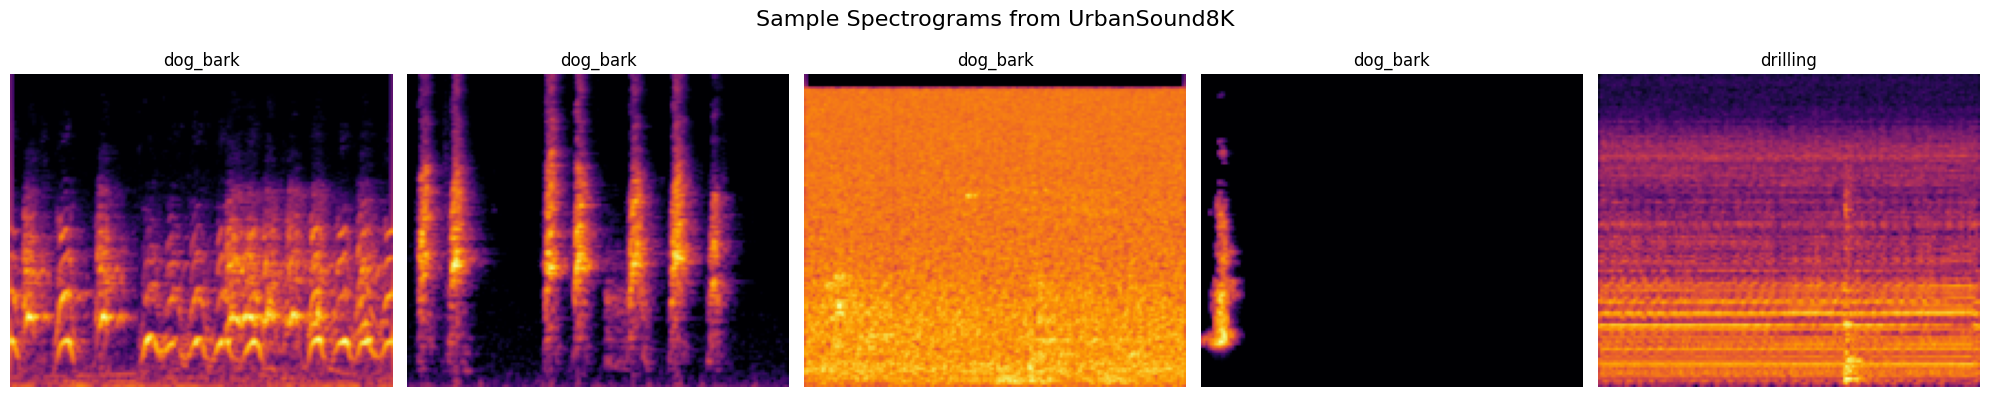

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Assuming: class_labels is a list like ["air_conditioner", "car_horn", ..., "street_music"]
class_labels = ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling',
                'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']

# Get 5 random samples from the training dataset
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i in range(5):
    idx = random.randint(0, len(train_dataset) - 1)
    spec, label = train_dataset[idx]

    # Move channel to last (from CxHxW to HxWxC if necessary)
    if spec.shape[0] == 1:  # (1, H, W)
        spec = spec.squeeze(0)

    axes[i].imshow(spec, origin='lower', aspect='auto', cmap='inferno')
    axes[i].set_title(class_labels[label])
    axes[i].axis('off')

plt.suptitle("Sample Spectrograms from UrbanSound8K", fontsize=16)
plt.tight_layout()
plt.show()
